# Learning Useful SPs from Wikipedia Text

We can use a stream of articles from wikipedia as a corpus for learning useful semantic pointers that capture various relationships between words. First, we'll set up the corpus, build a vocabulary of words to model, and check the size of this vocabulary:

In [1]:
import os
from embeddings import RandomIndexing
from corpora import Wikipedia

wiki = Wikipedia(path=os.getcwd()+'/wikipedia/', article_limit=100)
wiki.load_vocab('tutorial_words')

print('Vocab size: ', len(wiki.vocab))

Vocab size:  14924


### Context Encoding

Now, we can build a basic random indexing model to encode the word co-occurence patterns in these articles into a set of high-dimensional vectors. This method is related to well-known algorithms such as LSA, Word2Vec (i.e. CBOW + skip-gram encoding), and GloVe. One benefit of random indexing is that it is easy to parallelize, and hence efficient to run on large corpora:

In [2]:
dim = 512

model = RandomIndexing(wiki)
model.train(dim=dim, wordlist=wiki.vocab, flags=['context'], batchsize=100)
print('Computation time: ', model.runtime)

Computation time:  12.955912113189697


We can find the nearest neighbors to any word in the resulting 'semantic space' with just a few lines of code. Note that with this small amount of training data, the results will be specific to the topics of the wikipedia articles that have been chosen:

In [3]:
word_list = ['brain','movie','philosophy','political','oil','president']

for word in word_list:
    print('Nearest neighbors to "%s":' % word)
    model.get_nearest(word)
    print('')

Nearest neighbors to "brain":
brain 1.0
autism 0.482719270829
disorders 0.431223462006
hypothesizes 0.421037821424
diffusion 0.406571107305

Nearest neighbors to "movie":
movie 1.0
oscars 0.388022533051
picture 0.386882381116
conferred 0.37202252053
chances 0.364864475903

Nearest neighbors to "philosophy":
philosophy 1.0
metaphysics 0.61318627448
poetical 0.548708071504
logic 0.545480437691
theoretical 0.504074031182

Nearest neighbors to "political":
political 1.0
social 0.547131407219
economic 0.54543491821
government 0.539706920881
power 0.520555591159

Nearest neighbors to "oil":
oil 1.0
crude 0.804677235039
reserves 0.696746126835
sands 0.689746302217
petroleum 0.682390158621

Nearest neighbors to "president":
president 1.0
government 0.619202080505
presidential 0.580545854702
power 0.565907232342
lincoln 0.561240526704



### Order Encoding

To make the model a bit more interesting, we can encode positional information about the words that tend to occur around each target word in our voabulary. This amounts to adding information about ngrams in the corpus to each semantic vector. Computation is a bit more costly in this case, due to the need to compute several circular convolutions per word occurence. Again, though, this computation can be parallelized, so it's not too bad to implement.

In [4]:
model.train(dim=dim, wordlist=wiki.vocab, flags=['order'], batchsize=100)
print('Computation time: ', model.runtime)

Computation time:  44.344762086868286


The resulting vectors can be queried for likely words occuring in positions to left and right of a target word. We can also find words that tend to occur in the same 'order contexts' as a target word:

In [5]:
word_list = ['king','abraham','of','academy','argued','give','each','smallest']

for word in word_list:
    print('Likely words next to "%s":' % word)
    model.get_order_completions(word, position=1)
    print('')

Likely words next to "king":
of 0.57443948913
diatomic 0.160800123097
driven 0.15608508356
goto 0.155153476234
rupture 0.154560077595

Likely words next to "abraham":
lincoln 0.635985749054
became 0.228987218933
was 0.175729638394
freedom 0.172380710857
karl 0.169741238861

Likely words next to "of":
the 0.55075464884
retained 0.171044524436
yearend 0.170602723443
gills 0.155525676624
nationalism 0.153929979113

Likely words next to "academy":
awards 0.483823646548
of 0.319674694827
fusion 0.167788028739
purposes 0.162761848232
discretion 0.160095686802

Likely words next to "argued":
that 0.882071931377
hanson 0.196121308755
bonds 0.173961963386
behaves 0.167207538577
morocco 0.160188908936

Likely words next to "give":
the 0.273766341149
up 0.186127414351
pair 0.172831825054
venting 0.17098575083
meaningless 0.169791329506

Likely words next to "each":
other 0.456362070757
of 0.28614683538
concerns 0.173493371328
contradictory 0.165255655526
limbs 0.156787903135

Likely words next to

There's a more accurate way to find preceding and subsequent words - we simply look for order vectors that tend to encode the target word in particular positions.(It's helpful to consider why this is more accurate)

In [7]:
phrase_list = [ 'promoted __ rights', 'which lincoln promoted __ rights for', 'president __', 
               ' __ civil war', 'aristotle held more __ theories']

for phrase in phrase_list:
    print('Phrase completion for %s' % phrase)
    model.get_resonants(phrase)
    print('')

Phrase completion for promoted __ rights
womens 0.262810141569
voting 0.262042164951
lacked 0.171768277508
nothing 0.168861043148
rounded 0.167518179177

Phrase completion for which lincoln promoted __ rights for
voting 0.278843281101
asks 0.249397675761
descriptive 0.24782792937
desperate 0.240031331288
warrants 0.234872507407

Phrase completion for president __
abdelaziz 0.434404086616
sali 0.407114279307
barack 0.401388428771
stephens 0.378002219932
nicolas 0.347773673543

Phrase completion for  __ civil war
horrific 0.459219754447
spanish 0.247091510776
condemning 0.224804799034
devastating 0.217499235849
aversion 0.209073883859

Phrase completion for aristotle held more __ theories
accurate 0.408222379894
recently 0.341959338532
than 0.330895569306
efficient 0.307709706472
complex 0.30739589076



### Syntax Encoding

It is possible to extend the methods used for encoding order information to encode information about the syntactic structure of the sentences a word typically occurs in. We'll use dependency structures to model this information, primarily because they are simpler than constituency structures and thus easier to encode in vectors with a limited capacity for storing structured information (all the usual facts about HRR capacity apply here). Instead of encoding words to the left or right of a target word, we'll encode words that occur as parents or children of a target word in a dependency tree.

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://taweb.aichi-u.ac.jp/tmgross/pix/PSG-DG.png")

The resulting vectors can be used to query a target word for words that are commonly linked to it by a given dependency relation. 

In [9]:
model.train(dim=dim, wordlist=wiki.vocab, flags=['syntax'], batchsize=100)
print('Computation time: ', model.runtime)

Computation time:  21.879013061523438


In [10]:
word_list = ['notice','give','emphasized','presented','invited','appeals']

for word in word_list:
    print('Common nsubj for "%s":' % word)
    model.get_verb_completions(word, 'nsubj')
    print('')

for word in word_list:
    print('Common dobj for "%s":' % word)
    model.get_verb_completions(word, 'dobj')
    print('')

Common nsubj for "notice":
parents 0.534678252456
one 0.489546129555
broadcasting 0.170170041982
elder 0.157420893005
tried 0.155045247614

Common nsubj for "give":
he 0.19300148185
which 0.192824225911
forces 0.187580831608
none 0.185935319357
yuryevets 0.178073951621

Common nsubj for "emphasized":
he 0.31377949721
douglas 0.311736258305
change 0.29532005205
anthropology 0.278888407662
historians 0.266938271992

Common nsubj for "presented":
aruba 0.371237062549
they 0.230624238136
statuettes 0.214007281377
rand 0.20840321304
idealism 0.203376587666

Common nsubj for "invited":
leaders 0.282923280864
legislature 0.24892190193
they 0.242622722039
massoud 0.237031806475
government 0.225154786406

Common nsubj for "appeals":
who 0.426105574645
defendant 0.410865369367
party 0.371509988426
dagny 0.167833555625
staterun 0.163422007327

Common dobj for "notice":
colors 0.511212477806
signs 0.473584516216
kinship 0.203159554886
forts 0.17947452356
teaching 0.1691675435

Common dobj for "giv

In [11]:
for word in word_list:
    print('Likely counterparts to "%s":' % word)
    model.get_verb_neighbors(word)
    print('')

Likely counterparts to "notice":
notice 1.0
class 0.363665562229
grazed 0.35715918596
remembers 0.355812480473
touched 0.341009433454

Likely counterparts to "give":
give 1.0
gave 0.40778233999
recalled 0.307071259807
fought 0.293124204471
giving 0.280921546521

Likely counterparts to "emphasized":
emphasized 1.0
preserved 0.38192874388
adhered 0.335296547149
stated 0.33081216497
said 0.327748539451

Likely counterparts to "presented":
presented 1.0
extinguishing 0.280717568308
influenced 0.278342177993
gather 0.275606504481
reveal 0.258146316738

Likely counterparts to "invited":
invited 1.0
inviting 0.298846385815
perish 0.28797554879
eat 0.244524503383
invested 0.242880905063

Likely counterparts to "appeals":
appeals 1.0
grabbing 0.535491293784
grasping 0.463539748069
mounted 0.463539748069
narrow 0.463539748069



# Using Learned SPs in a Nengo Model

When using the SPA system, we often specify vocabularies that contain various semantic pointers that the components in a SPA model then become aware of. Because we can specify the elements in these vocabularies directly, we can use the vectors we just learned from wikipedia to produce vocabularies that possess SPs with interesting semantic properties. This is a nice alterative to using the default, random SPs.

In [12]:
import nengo
import nengo.spa as spa

import matplotlib.pyplot as plt
%matplotlib inline

words = ['go','abraham','was','a','the','to','race','politician','agreement','also','test','walked','chase','related',
        'ants','alone','heidegger','light','water','disorders','resumed','refuse','anger','just','help','trade','court',
        'commonly','lincoln','moment','wine','hamlet','aardvark','differently','materials','occurring','surface',
        'phrase','car','dirt','at','trust','brain','physiology','house','martin','womens','voting','accurate']

context_vocab = spa.Vocabulary(dim)
order_vocab = spa.Vocabulary(dim)
syntax_vocab = spa.Vocabulary(dim)

for word in words:
    context_vocab.add(word.upper(), model.context_vectors[model.word_to_index[word], :])
    order_vocab.add(word.upper(), model.order_vectors[model.word_to_index[word], :])
    syntax_vocab.add(word.upper(), model.syntax_vectors[model.word_to_index[word], :])

As an initial illustration, we can build a simple SPA model that estimates how related two words are. This takes just a few lines of code to implement:

In [13]:
def first_word(t):
    return 'AARDVARK'

def second_word(t):
    return 'ANTS'
    
with spa.SPA() as simple_model:
    simple_model.word_1 = spa.State(dimensions=dim, vocab=context_vocab)
    simple_model.word_2 = spa.State(dimensions=dim, vocab=context_vocab)
    simple_model.relate = spa.Compare(dimensions=dim, vocab=context_vocab)
    
    nengo.Connection(simple_model.word_1.output, simple_model.relate.inputA)
    nengo.Connection(simple_model.word_2.output, simple_model.relate.inputB)
    
    simple_model.inputs = spa.Input(word_1=first_word, word_2=second_word)
    
    word_1_probe = nengo.Probe(simple_model.word_1.output, synapse=0.03)
    word_2_probe = nengo.Probe(simple_model.word_2.output, synapse=0.03)
    relate_probe = nengo.Probe(simple_model.relate.output, synapse=0.1)

sim = nengo.Simulator(simple_model)
sim.run(0.5)

Simulation finished in 0:00:33.                                                                                                                                                                             


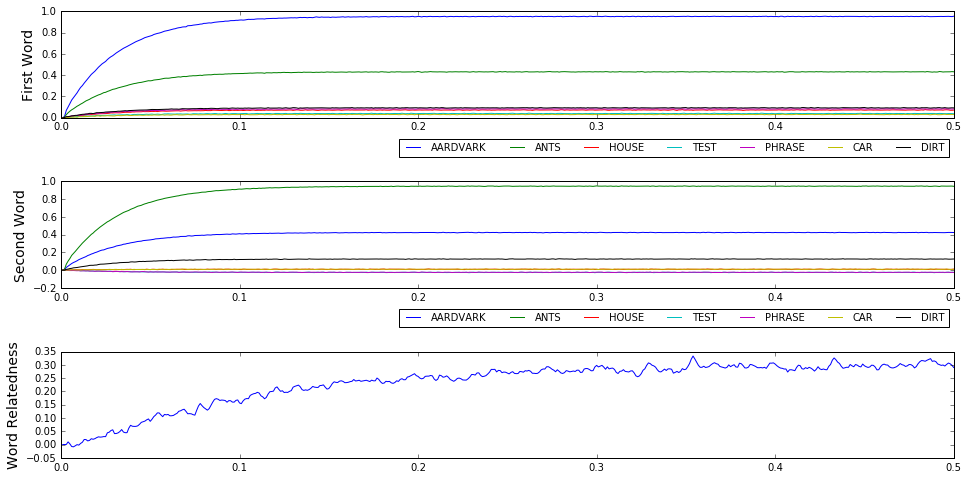

In [14]:
plotting_vocab = context_vocab.create_subset(['AARDVARK','ANTS','HOUSE','TEST','PHRASE','CAR','DIRT'])

fig = plt.figure(figsize=(16,8))
n = 3
p1 = fig.add_subplot(n,1,1)
p1.plot(sim.trange(), simple_model.similarity(sim.data, word_1_probe, vocab=plotting_vocab))
p1.legend(plotting_vocab.keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
p1.set_ylabel('First Word', fontsize=14)

p2 = fig.add_subplot(n,1,2)
p2.plot(sim.trange(), simple_model.similarity(sim.data, word_2_probe, vocab=plotting_vocab))
p2.legend(plotting_vocab.keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
p2.set_ylabel('Second Word', fontsize=14)

p3 = fig.add_subplot(n,1,3)
p3.plot(sim.trange(), sim.data[relate_probe])
p3.set_ylabel('Word Relatedness', fontsize=14)

fig.subplots_adjust(hspace=0.6)
plt.show()

We can check how well this nengo model is measuring the relatedness of these two terms by showing the true dot product of the underlying vectors:

In [15]:
model.get_nearest('aardvark')

aardvark 1.0
ants 0.45034018227
creature 0.400011417048
burrows 0.39710318059
termites 0.379409550426


For a slightly more complicated model, let's build a network that predicts the next word given some sequence of words. To do so, we'll match vectors that encode a sequence of n words to the vectors corresponding to the next word using an associative memory. 

In [16]:
order_vocab.add('TEST_PHRASE_1', model.get_vector_encoding('promoted __ rights'))
order_vocab.add('TEST_PHRASE_2', model.get_vector_encoding( 'which lincoln promoted __ rights for'))
order_vocab.add('TEST_PHRASE_3', model.get_vector_encoding('aristotle held more __ theories'))

uppercase_words = [w.upper() for w in words]

def built_phrase(t):
    if t < 0.35:
        return 'TEST_PHRASE_1'
    elif 0.45 < t < 0.7:
        return 'TEST_PHRASE_2'
    elif 0.75 < t:
        return 'TEST_PHRASE_3'
    else:
        return '0'
    
with spa.SPA() as ngram_model:
    ngram_model.ngram = spa.State(dimensions=dim, vocab=order_vocab)
    ngram_model.match = spa.AssociativeMemory(order_vocab, input_keys=uppercase_words, output_keys=uppercase_words,
                                              threshold=0.2)
    
    nengo.Connection(ngram_model.ngram.output, ngram_model.match.input)
    
    ngram_model.input = spa.Input(ngram=built_phrase)
    
    ngram_probe = nengo.Probe(ngram_model.ngram.output, synapse=0.03)
    match_probe = nengo.Probe(ngram_model.match.output, synapse=0.1)
    
sim = nengo.Simulator(ngram_model)
sim.run(1)

Simulation finished in 0:00:07.                                                                                                                                                                             


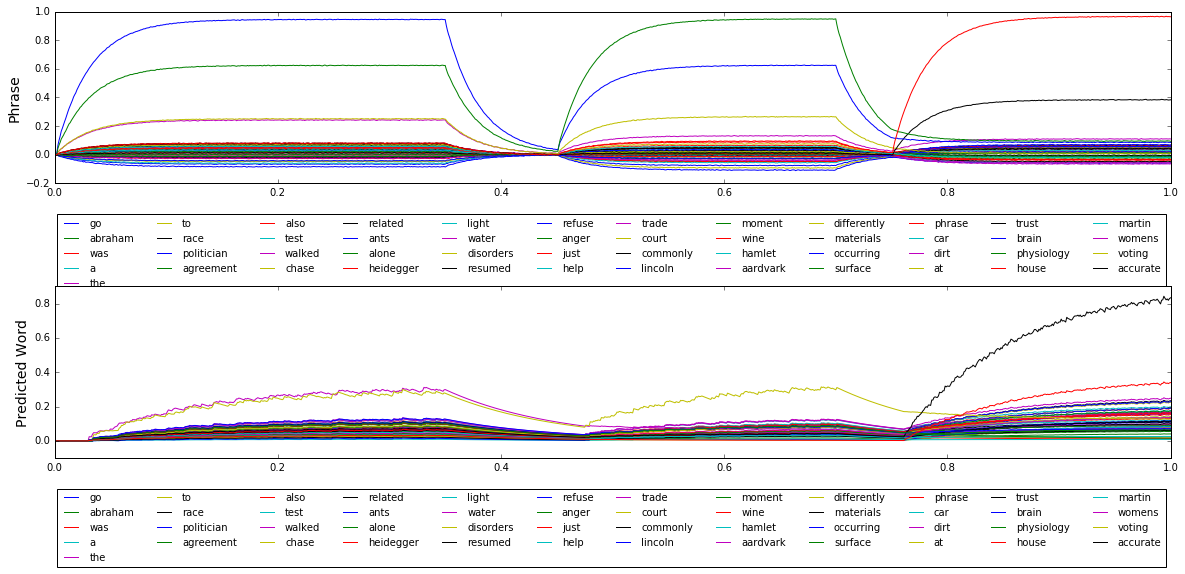

In [17]:
fig = plt.figure(figsize=(20,8))
p1 = fig.add_subplot(2,1,1)
p1.plot(sim.trange(), simple_model.similarity(sim.data, ngram_probe, vocab=order_vocab))
p1.legend(words, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=12)
p1.set_ylabel('Phrase', fontsize=14)

p2 = fig.add_subplot(2,1,2)
p2.plot(sim.trange(), simple_model.similarity(sim.data, match_probe, vocab=order_vocab))
p2.legend(words, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=12)
p2.set_ylabel('Predicted Word', fontsize=14)

fig.subplots_adjust(hspace=0.6)
plt.show()